In [4]:
# 100 Iterations only shirt class
import os
import json
from detectron2 import model_zoo
from detectron2.config import get_cfg
from detectron2.engine import DefaultTrainer, DefaultPredictor
from detectron2.data import DatasetCatalog, MetadataCatalog, build_detection_train_loader
from detectron2.data.datasets import register_coco_instances
import cv2

# Step 1: Define a custom dataset class to load your dataset
def load_dataset():
    dataset_dicts = []
    images_folder = "images"
    annotations_file = "annotations.json"
    with open(annotations_file) as f:
        data = json.load(f)
    for img in data["images"]:
        record = {}
        filename = os.path.join(images_folder, img["file_name"])
        record["file_name"] = filename
        record["image_id"] = img["id"]
        record["height"] = img["height"]
        record["width"] = img["width"]
        objs = []
        for ann in data["annotations"]:
            if ann["image_id"] == img["id"]:
                obj = {
                    "bbox": ann["bbox"],
                    "bbox_mode": 0,  # Use BoxMode.XYWH_ABS if annotations are in absolute coordinates
                    "category_id": ann["category_id"],
                }
                objs.append(obj)
        record["annotations"] = objs
        dataset_dicts.append(record)
    return dataset_dicts

# Unregister the dataset if it's already registered
if "shirt_dataset_train" in DatasetCatalog:
    DatasetCatalog.remove("shirt_dataset_train")

# Register the dataset
register_coco_instances("shirt_dataset_train", {}, "annotations.json", "images")

# Load metadata
MetadataCatalog.get("shirt_dataset_train").set(thing_classes=["Shirt"])
shirt_metadata = MetadataCatalog.get("shirt_dataset_train")

# Step 2: Configure and initialize the model for training
cfg = get_cfg()
cfg.merge_from_file("detectron2/COCO-InstanceSegmentation/mask_rcnn_R_50_FPN_3x.yaml")
cfg.DATASETS.TRAIN = ("shirt_dataset_train",)
cfg.DATASETS.TEST = ()  # No test dataset
cfg.DATALOADER.NUM_WORKERS = 2
cfg.MODEL.WEIGHTS = model_zoo.get_checkpoint_url("COCO-InstanceSegmentation/mask_rcnn_R_50_FPN_3x.yaml")
cfg.SOLVER.IMS_PER_BATCH = 2
cfg.SOLVER.BASE_LR = 0.0025
cfg.SOLVER.MAX_ITER = 100  # You can adjust this
cfg.SOLVER.STEPS = []  # You can add learning rate steps here
cfg.MODEL.ROI_HEADS.BATCH_SIZE_PER_IMAGE = 128  # You can adjust this
cfg.MODEL.ROI_HEADS.NUM_CLASSES = 1  # Only one class (Shirt)

# Enable mask prediction
cfg.MODEL.MASK_ON = True

# Step 3: Train the model
os.makedirs(cfg.OUTPUT_DIR, exist_ok=True)
trainer = DefaultTrainer(cfg)
trainer.resume_or_load(resume=False)
trainer.train()

import torch
# Save the trained model
output_model_path = os.path.join(cfg.OUTPUT_DIR, "trained_model.pth")
torch.save(trainer.model.state_dict(), output_model_path)

# Step 4: Use the trained model for inference on a sample image
# Load the trained model
cfg.MODEL.WEIGHTS = output_model_path
cfg.MODEL.ROI_HEADS.SCORE_THRESH_TEST = 0.5  # Set a threshold for this model
predictor = DefaultPredictor(cfg)

# Load a sample image
sample_image_path = "C://Users//admin//Desktop//New folder//images//00e745c9-97d9-429d-8c3f-d3db7a2d2991.jpg"
sample_image = cv2.imread(sample_image_path)

# Perform inference
outputs = predictor(sample_image)

# Visualize the predictions
v = Visualizer(sample_image[:, :, ::-1], metadata=shirt_metadata, scale=0.8)
v = v.draw_instance_predictions(outputs["instances"].to("cpu"))

# Save the visualized image
output_image_path = "sample_result.jpg"
cv2.imwrite(output_image_path, v.get_image()[:, :, ::-1])


[04/29 06:27:44 d2.engine.defaults]: Model:
GeneralizedRCNN(
  (backbone): FPN(
    (fpn_lateral2): Conv2d(256, 256, kernel_size=(1, 1), stride=(1, 1))
    (fpn_output2): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (fpn_lateral3): Conv2d(512, 256, kernel_size=(1, 1), stride=(1, 1))
    (fpn_output3): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (fpn_lateral4): Conv2d(1024, 256, kernel_size=(1, 1), stride=(1, 1))
    (fpn_output4): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (fpn_lateral5): Conv2d(2048, 256, kernel_size=(1, 1), stride=(1, 1))
    (fpn_output5): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (top_block): LastLevelMaxPool()
    (bottom_up): ResNet(
      (stem): BasicStem(
        (conv1): Conv2d(
          3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False
          (norm): FrozenBatchNorm2d(num_features=64, eps=1e-05)
        )
      )
      (res

Skip loading parameter 'roi_heads.box_predictor.cls_score.weight' to the model due to incompatible shapes: (81, 1024) in the checkpoint but (2, 1024) in the model! You might want to double check if this is expected.
Skip loading parameter 'roi_heads.box_predictor.cls_score.bias' to the model due to incompatible shapes: (81,) in the checkpoint but (2,) in the model! You might want to double check if this is expected.
Skip loading parameter 'roi_heads.box_predictor.bbox_pred.weight' to the model due to incompatible shapes: (320, 1024) in the checkpoint but (4, 1024) in the model! You might want to double check if this is expected.
Skip loading parameter 'roi_heads.box_predictor.bbox_pred.bias' to the model due to incompatible shapes: (320,) in the checkpoint but (4,) in the model! You might want to double check if this is expected.
Skip loading parameter 'roi_heads.mask_head.predictor.weight' to the model due to incompatible shapes: (80, 256, 1, 1) in the checkpoint but (1, 256, 1, 1) in

[04/29 06:27:44 d2.engine.train_loop]: Starting training from iteration 0


C:\Users\admin\Desktop\New folder\detectron2\layers\wrappers.py:127: UserWarning: Plan failed with a cudnnException: CUDNN_BACKEND_EXECUTION_PLAN_DESCRIPTOR: cudnnFinalize Descriptor Failed cudnn_status: CUDNN_STATUS_NOT_SUPPORTED (Triggered internally at C:\cb\pytorch_1000000000000\work\aten\src\ATen\native\cudnn\Conv_v8.cpp:919.)
  x = F.conv2d(
C:\Users\admin\Desktop\New folder\detectron2\layers\wrappers.py:127: UserWarning: Plan failed with a cudnnException: CUDNN_BACKEND_EXECUTION_PLAN_DESCRIPTOR: cudnnFinalize Descriptor Failed cudnn_status: CUDNN_STATUS_NOT_SUPPORTED (Triggered internally at C:\cb\pytorch_1000000000000\work\aten\src\ATen\native\cudnn\Conv_v8.cpp:919.)
  x = F.conv2d(
C:\Users\admin\Desktop\New folder\detectron2\layers\wrappers.py:127: UserWarning: Plan failed with a cudnnException: CUDNN_BACKEND_EXECUTION_PLAN_DESCRIPTOR: cudnnFinalize Descriptor Failed cudnn_status: CUDNN_STATUS_NOT_SUPPORTED (Triggered internally at C:\cb\pytorch_1000000000000\work\aten\src\AT

[04/29 06:49:06 d2.utils.events]:  eta: 1:26:03  iter: 19  total_loss: 1.359  loss_cls: 0.3249  loss_box_reg: 0.3438  loss_mask: 0.6245  loss_rpn_cls: 0.001862  loss_rpn_loc: 0.01728    time: 63.2601  last_time: 63.3498  data_time: 0.4219  last_data_time: 0.0037   lr: 0.00047703  max_mem: 3950M


C:\Users\admin\Desktop\New folder\detectron2\layers\wrappers.py:127: UserWarning: Plan failed with a cudnnException: CUDNN_BACKEND_EXECUTION_PLAN_DESCRIPTOR: cudnnFinalize Descriptor Failed cudnn_status: CUDNN_STATUS_NOT_SUPPORTED (Triggered internally at C:\cb\pytorch_1000000000000\work\aten\src\ATen\native\cudnn\Conv_v8.cpp:919.)
  x = F.conv2d(
C:\Users\admin\Desktop\New folder\detectron2\layers\wrappers.py:127: UserWarning: Plan failed with a cudnnException: CUDNN_BACKEND_EXECUTION_PLAN_DESCRIPTOR: cudnnFinalize Descriptor Failed cudnn_status: CUDNN_STATUS_NOT_SUPPORTED (Triggered internally at C:\cb\pytorch_1000000000000\work\aten\src\ATen\native\cudnn\Conv_v8.cpp:919.)
  x = F.conv2d(
C:\Users\admin\Desktop\New folder\detectron2\layers\wrappers.py:127: UserWarning: Plan failed with a cudnnException: CUDNN_BACKEND_EXECUTION_PLAN_DESCRIPTOR: cudnnFinalize Descriptor Failed cudnn_status: CUDNN_STATUS_NOT_SUPPORTED (Triggered internally at C:\cb\pytorch_1000000000000\work\aten\src\AT

[04/29 07:08:44 d2.utils.events]:  eta: 1:03:42  iter: 39  total_loss: 0.5758  loss_cls: 0.0554  loss_box_reg: 0.2698  loss_mask: 0.2049  loss_rpn_cls: 0.00114  loss_rpn_loc: 0.009136    time: 60.9713  last_time: 64.0831  data_time: 0.0073  last_data_time: 0.0033   lr: 0.00097653  max_mem: 4040M


C:\Users\admin\Desktop\New folder\detectron2\layers\wrappers.py:127: UserWarning: Plan failed with a cudnnException: CUDNN_BACKEND_EXECUTION_PLAN_DESCRIPTOR: cudnnFinalize Descriptor Failed cudnn_status: CUDNN_STATUS_NOT_SUPPORTED (Triggered internally at C:\cb\pytorch_1000000000000\work\aten\src\ATen\native\cudnn\Conv_v8.cpp:919.)
  x = F.conv2d(
C:\Users\admin\Desktop\New folder\detectron2\layers\wrappers.py:127: UserWarning: Plan failed with a cudnnException: CUDNN_BACKEND_EXECUTION_PLAN_DESCRIPTOR: cudnnFinalize Descriptor Failed cudnn_status: CUDNN_STATUS_NOT_SUPPORTED (Triggered internally at C:\cb\pytorch_1000000000000\work\aten\src\ATen\native\cudnn\Conv_v8.cpp:919.)
  x = F.conv2d(
C:\Users\admin\Desktop\New folder\detectron2\layers\wrappers.py:127: UserWarning: Plan failed with a cudnnException: CUDNN_BACKEND_EXECUTION_PLAN_DESCRIPTOR: cudnnFinalize Descriptor Failed cudnn_status: CUDNN_STATUS_NOT_SUPPORTED (Triggered internally at C:\cb\pytorch_1000000000000\work\aten\src\AT

[04/29 07:29:14 d2.utils.events]:  eta: 0:42:49  iter: 59  total_loss: 0.2926  loss_cls: 0.02623  loss_box_reg: 0.1695  loss_mask: 0.08476  loss_rpn_cls: 0.0005967  loss_rpn_loc: 0.01574    time: 61.1389  last_time: 65.5971  data_time: 0.0058  last_data_time: 0.0118   lr: 0.001476  max_mem: 4040M


C:\Users\admin\Desktop\New folder\detectron2\layers\wrappers.py:127: UserWarning: Plan failed with a cudnnException: CUDNN_BACKEND_EXECUTION_PLAN_DESCRIPTOR: cudnnFinalize Descriptor Failed cudnn_status: CUDNN_STATUS_NOT_SUPPORTED (Triggered internally at C:\cb\pytorch_1000000000000\work\aten\src\ATen\native\cudnn\Conv_v8.cpp:919.)
  x = F.conv2d(
C:\Users\admin\Desktop\New folder\detectron2\layers\wrappers.py:127: UserWarning: Plan failed with a cudnnException: CUDNN_BACKEND_EXECUTION_PLAN_DESCRIPTOR: cudnnFinalize Descriptor Failed cudnn_status: CUDNN_STATUS_NOT_SUPPORTED (Triggered internally at C:\cb\pytorch_1000000000000\work\aten\src\ATen\native\cudnn\Conv_v8.cpp:919.)
  x = F.conv2d(
C:\Users\admin\Desktop\New folder\detectron2\layers\wrappers.py:127: UserWarning: Plan failed with a cudnnException: CUDNN_BACKEND_EXECUTION_PLAN_DESCRIPTOR: cudnnFinalize Descriptor Failed cudnn_status: CUDNN_STATUS_NOT_SUPPORTED (Triggered internally at C:\cb\pytorch_1000000000000\work\aten\src\AT

[04/29 07:49:44 d2.utils.events]:  eta: 0:21:14  iter: 79  total_loss: 0.1821  loss_cls: 0.01907  loss_box_reg: 0.07668  loss_mask: 0.05752  loss_rpn_cls: 0.000361  loss_rpn_loc: 0.01064    time: 61.2327  last_time: 52.9903  data_time: 0.0034  last_data_time: 0.0021   lr: 0.0019755  max_mem: 4041M


C:\Users\admin\Desktop\New folder\detectron2\layers\wrappers.py:127: UserWarning: Plan failed with a cudnnException: CUDNN_BACKEND_EXECUTION_PLAN_DESCRIPTOR: cudnnFinalize Descriptor Failed cudnn_status: CUDNN_STATUS_NOT_SUPPORTED (Triggered internally at C:\cb\pytorch_1000000000000\work\aten\src\ATen\native\cudnn\Conv_v8.cpp:919.)
  x = F.conv2d(
C:\Users\admin\Desktop\New folder\detectron2\layers\wrappers.py:127: UserWarning: Plan failed with a cudnnException: CUDNN_BACKEND_EXECUTION_PLAN_DESCRIPTOR: cudnnFinalize Descriptor Failed cudnn_status: CUDNN_STATUS_NOT_SUPPORTED (Triggered internally at C:\cb\pytorch_1000000000000\work\aten\src\ATen\native\cudnn\Conv_v8.cpp:919.)
  x = F.conv2d(


[04/29 08:10:25 d2.utils.events]:  eta: 0:00:00  iter: 99  total_loss: 0.1344  loss_cls: 0.01584  loss_box_reg: 0.0559  loss_mask: 0.04884  loss_rpn_cls: 0.0004322  loss_rpn_loc: 0.009185    time: 61.3790  last_time: 51.6777  data_time: 0.0037  last_data_time: 0.0020   lr: 0.002475  max_mem: 4041M
[04/29 08:10:25 d2.engine.hooks]: Overall training speed: 98 iterations in 1:40:15 (61.3790 s / it)
[04/29 08:10:25 d2.engine.hooks]: Total training time: 1:40:17 (0:00:02 on hooks)
[04/29 08:10:27 d2.checkpoint.detection_checkpoint]: [DetectionCheckpointer] Loading from ./output\trained_model.pth ...


C:\Users\admin\Desktop\New folder\detectron2\layers\wrappers.py:127: UserWarning: Plan failed with a cudnnException: CUDNN_BACKEND_EXECUTION_PLAN_DESCRIPTOR: cudnnFinalize Descriptor Failed cudnn_status: CUDNN_STATUS_NOT_SUPPORTED (Triggered internally at C:\cb\pytorch_1000000000000\work\aten\src\ATen\native\cudnn\Conv_v8.cpp:919.)
  x = F.conv2d(
C:\Users\admin\Desktop\New folder\detectron2\layers\wrappers.py:127: UserWarning: Plan failed with a cudnnException: CUDNN_BACKEND_EXECUTION_PLAN_DESCRIPTOR: cudnnFinalize Descriptor Failed cudnn_status: CUDNN_STATUS_NOT_SUPPORTED (Triggered internally at C:\cb\pytorch_1000000000000\work\aten\src\ATen\native\cudnn\Conv_v8.cpp:919.)
  x = F.conv2d(


True

50 Iterations only Shirt class

In [16]:
import os
import json
from detectron2 import model_zoo
from detectron2.config import get_cfg
from detectron2.engine import DefaultTrainer, DefaultPredictor
from detectron2.data import DatasetCatalog, MetadataCatalog
from detectron2.data.datasets import register_coco_instances
from detectron2.utils.visualizer import Visualizer
import cv2
import numpy as np

# Load the trained model
output_model_path = "./output/trained_model.pth"  # Update with the path to your trained model
cfg = get_cfg()
cfg.MODEL.WEIGHTS = output_model_path
cfg.MODEL.ROI_HEADS.SCORE_THRESH_TEST = 0.5  # Set a threshold for this model
predictor = DefaultPredictor(cfg)

# Load a sample image
sample_image_path = "C://Users//admin//Desktop//New folder//images//00e745c9-97d9-429d-8c3f-d3db7a2d2991.jpg" # Update with the path to your sample image
sample_image = cv2.imread(sample_image_path)

# Perform inference
outputs = predictor(sample_image)

# Get the predicted instances
instances = outputs["instances"].to("cpu")

# Extract the predicted bounding boxes and classes
pred_boxes = instances.pred_boxes.tensor.numpy()
pred_classes = instances.pred_classes.numpy()

# Create a copy of the sample image
processed_image = sample_image.copy()

# Replace the background with white for each detected object
for bbox, class_id in zip(pred_boxes, pred_classes):
    # Convert bounding box coordinates to integers
    bbox = bbox.astype(int)
    
    # Replace the background of the object region with white
    processed_image[bbox[1]:bbox[3], bbox[0]:bbox[2]][...] = (255, 255, 255)

# Save the resulting image
output_image_path = "output_image.jpg"
cv2.imwrite(output_image_path, processed_image)





[04/29 14:11:44 d2.checkpoint.detection_checkpoint]: [DetectionCheckpointer] Loading from ./output/trained_model.pth ...


Skip loading parameter 'proposal_generator.rpn_head.conv.weight' to the model due to incompatible shapes: (256, 256, 3, 3) in the checkpoint but (1024, 1024, 3, 3) in the model! You might want to double check if this is expected.
Skip loading parameter 'proposal_generator.rpn_head.conv.bias' to the model due to incompatible shapes: (256,) in the checkpoint but (1024,) in the model! You might want to double check if this is expected.
Skip loading parameter 'proposal_generator.rpn_head.objectness_logits.weight' to the model due to incompatible shapes: (3, 256, 1, 1) in the checkpoint but (15, 1024, 1, 1) in the model! You might want to double check if this is expected.
Skip loading parameter 'proposal_generator.rpn_head.objectness_logits.bias' to the model due to incompatible shapes: (3,) in the checkpoint but (15,) in the model! You might want to double check if this is expected.
Skip loading parameter 'proposal_generator.rpn_head.anchor_deltas.weight' to the model due to incompatible s

True

50 iterations only Shirt Class

In [22]:
import os
import json
from detectron2 import model_zoo
from detectron2.config import get_cfg
from detectron2.engine import DefaultTrainer, DefaultPredictor
from detectron2.data import DatasetCatalog, MetadataCatalog, build_detection_train_loader
from detectron2.data.datasets import register_coco_instances
import cv2

# Step 1: Define a custom dataset class to load your dataset
def load_dataset():
    dataset_dicts = []
    images_folder = "images"
    annotations_file = "annotations.json"
    with open(annotations_file) as f:
        data = json.load(f)
    for img in data["images"]:
        record = {}
        filename = os.path.join(images_folder, img["file_name"])
        record["file_name"] = filename
        record["image_id"] = img["id"]
        record["height"] = img["height"]
        record["width"] = img["width"]
        objs = []
        for ann in data["annotations"]:
            if ann["image_id"] == img["id"]:
                obj = {
                    "bbox": ann["bbox"],
                    "bbox_mode": 0,  # Use BoxMode.XYWH_ABS if annotations are in absolute coordinates
                    "category_id": ann["category_id"],
                }
                objs.append(obj)
        record["annotations"] = objs
        dataset_dicts.append(record)
    return dataset_dicts

# Unregister the dataset if it's already registered
if "shirt_dataset_train" in DatasetCatalog:
    DatasetCatalog.remove("shirt_dataset_train")

# Register the dataset
register_coco_instances("shirt_dataset_train", {}, "annotations.json", "images")

# Load metadata
MetadataCatalog.get("shirt_dataset_train").set(thing_classes=["Shirt"])
shirt_metadata = MetadataCatalog.get("shirt_dataset_train")

# Step 2: Configure and initialize the model for training
cfg = get_cfg()
cfg.merge_from_file("detectron2/COCO-InstanceSegmentation/mask_rcnn_R_50_FPN_3x.yaml")
cfg.DATASETS.TRAIN = ("shirt_dataset_train",)
cfg.DATASETS.TEST = ()  # No test dataset
cfg.DATALOADER.NUM_WORKERS = 2
cfg.MODEL.WEIGHTS = model_zoo.get_checkpoint_url("COCO-InstanceSegmentation/mask_rcnn_R_50_FPN_3x.yaml")
cfg.SOLVER.IMS_PER_BATCH = 2
cfg.SOLVER.BASE_LR = 0.0025
cfg.SOLVER.MAX_ITER = 50  # You can adjust this
cfg.SOLVER.STEPS = []  # You can add learning rate steps here
cfg.MODEL.ROI_HEADS.BATCH_SIZE_PER_IMAGE = 128  # You can adjust this
cfg.MODEL.ROI_HEADS.NUM_CLASSES = 1  # Only one class (Shirt)

# Enable mask prediction
cfg.MODEL.MASK_ON = True

# Step 3: Train the model
os.makedirs(cfg.OUTPUT_DIR, exist_ok=True)
trainer = DefaultTrainer(cfg)
trainer.resume_or_load(resume=False)
trainer.train()

import torch
# Save the trained model
output_model_path = os.path.join(cfg.OUTPUT_DIR, "trained_model.pth")
torch.save(trainer.model.state_dict(), output_model_path)

# Step 4: Use the trained model for inference on a sample image
# Load the trained model
cfg.MODEL.WEIGHTS = output_model_path
cfg.MODEL.ROI_HEADS.SCORE_THRESH_TEST = 0.5  # Set a threshold for this model
predictor = DefaultPredictor(cfg)

# Load a sample image
sample_image_path = "C://Users//admin//Desktop//New folder//images//00e745c9-97d9-429d-8c3f-d3db7a2d2991.jpg"
sample_image = cv2.imread(sample_image_path)

# Perform inference
outputs = predictor(sample_image)

# Visualize the predictions
v = Visualizer(sample_image[:, :, ::-1], metadata=shirt_metadata, scale=0.8)
v = v.draw_instance_predictions(outputs["instances"].to("cpu"))

# Save the visualized image
output_image_path = "sample_result.jpg"
cv2.imwrite(output_image_path, v.get_image()[:, :, ::-1])


[04/29 14:48:14 d2.engine.defaults]: Model:
GeneralizedRCNN(
  (backbone): FPN(
    (fpn_lateral2): Conv2d(256, 256, kernel_size=(1, 1), stride=(1, 1))
    (fpn_output2): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (fpn_lateral3): Conv2d(512, 256, kernel_size=(1, 1), stride=(1, 1))
    (fpn_output3): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (fpn_lateral4): Conv2d(1024, 256, kernel_size=(1, 1), stride=(1, 1))
    (fpn_output4): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (fpn_lateral5): Conv2d(2048, 256, kernel_size=(1, 1), stride=(1, 1))
    (fpn_output5): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (top_block): LastLevelMaxPool()
    (bottom_up): ResNet(
      (stem): BasicStem(
        (conv1): Conv2d(
          3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False
          (norm): FrozenBatchNorm2d(num_features=64, eps=1e-05)
        )
      )
      (res

Skip loading parameter 'roi_heads.box_predictor.cls_score.weight' to the model due to incompatible shapes: (81, 1024) in the checkpoint but (2, 1024) in the model! You might want to double check if this is expected.
Skip loading parameter 'roi_heads.box_predictor.cls_score.bias' to the model due to incompatible shapes: (81,) in the checkpoint but (2,) in the model! You might want to double check if this is expected.
Skip loading parameter 'roi_heads.box_predictor.bbox_pred.weight' to the model due to incompatible shapes: (320, 1024) in the checkpoint but (4, 1024) in the model! You might want to double check if this is expected.
Skip loading parameter 'roi_heads.box_predictor.bbox_pred.bias' to the model due to incompatible shapes: (320,) in the checkpoint but (4,) in the model! You might want to double check if this is expected.
Skip loading parameter 'roi_heads.mask_head.predictor.weight' to the model due to incompatible shapes: (80, 256, 1, 1) in the checkpoint but (1, 256, 1, 1) in

[04/29 14:48:19 d2.engine.train_loop]: Starting training from iteration 0


C:\Users\admin\Desktop\New folder\detectron2\layers\wrappers.py:127: UserWarning: Plan failed with a cudnnException: CUDNN_BACKEND_EXECUTION_PLAN_DESCRIPTOR: cudnnFinalize Descriptor Failed cudnn_status: CUDNN_STATUS_NOT_SUPPORTED (Triggered internally at C:\cb\pytorch_1000000000000\work\aten\src\ATen\native\cudnn\Conv_v8.cpp:919.)
  x = F.conv2d(
C:\Users\admin\Desktop\New folder\detectron2\layers\wrappers.py:127: UserWarning: Plan failed with a cudnnException: CUDNN_BACKEND_EXECUTION_PLAN_DESCRIPTOR: cudnnFinalize Descriptor Failed cudnn_status: CUDNN_STATUS_NOT_SUPPORTED (Triggered internally at C:\cb\pytorch_1000000000000\work\aten\src\ATen\native\cudnn\Conv_v8.cpp:919.)
  x = F.conv2d(
C:\Users\admin\Desktop\New folder\detectron2\layers\wrappers.py:127: UserWarning: Plan failed with a cudnnException: CUDNN_BACKEND_EXECUTION_PLAN_DESCRIPTOR: cudnnFinalize Descriptor Failed cudnn_status: CUDNN_STATUS_NOT_SUPPORTED (Triggered internally at C:\cb\pytorch_1000000000000\work\aten\src\AT

[04/29 15:01:33 d2.utils.events]:  eta: 0:20:12  iter: 19  total_loss: 1.211  loss_cls: 0.2532  loss_box_reg: 0.3484  loss_mask: 0.5816  loss_rpn_cls: 0.001018  loss_rpn_loc: 0.01225    time: 39.8370  last_time: 31.6661  data_time: 0.5913  last_data_time: 0.0028   lr: 0.00095155  max_mem: 4041M


C:\Users\admin\Desktop\New folder\detectron2\layers\wrappers.py:127: UserWarning: Plan failed with a cudnnException: CUDNN_BACKEND_EXECUTION_PLAN_DESCRIPTOR: cudnnFinalize Descriptor Failed cudnn_status: CUDNN_STATUS_NOT_SUPPORTED (Triggered internally at C:\cb\pytorch_1000000000000\work\aten\src\ATen\native\cudnn\Conv_v8.cpp:919.)
  x = F.conv2d(
C:\Users\admin\Desktop\New folder\detectron2\layers\wrappers.py:127: UserWarning: Plan failed with a cudnnException: CUDNN_BACKEND_EXECUTION_PLAN_DESCRIPTOR: cudnnFinalize Descriptor Failed cudnn_status: CUDNN_STATUS_NOT_SUPPORTED (Triggered internally at C:\cb\pytorch_1000000000000\work\aten\src\ATen\native\cudnn\Conv_v8.cpp:919.)
  x = F.conv2d(
C:\Users\admin\Desktop\New folder\detectron2\layers\wrappers.py:127: UserWarning: Plan failed with a cudnnException: CUDNN_BACKEND_EXECUTION_PLAN_DESCRIPTOR: cudnnFinalize Descriptor Failed cudnn_status: CUDNN_STATUS_NOT_SUPPORTED (Triggered internally at C:\cb\pytorch_1000000000000\work\aten\src\AT

[04/29 15:14:58 d2.utils.events]:  eta: 0:06:47  iter: 39  total_loss: 0.4649  loss_cls: 0.04606  loss_box_reg: 0.2637  loss_mask: 0.1326  loss_rpn_cls: 0.000814  loss_rpn_loc: 0.01569    time: 40.0583  last_time: 34.6340  data_time: 0.0078  last_data_time: 0.0047   lr: 0.0019506  max_mem: 4041M
[04/29 15:21:35 d2.utils.events]:  eta: 0:00:00  iter: 49  total_loss: 0.2942  loss_cls: 0.02564  loss_box_reg: 0.1655  loss_mask: 0.08133  loss_rpn_cls: 0.0004443  loss_rpn_loc: 0.01427    time: 39.9550  last_time: 48.9550  data_time: 0.0080  last_data_time: 0.0124   lr: 0.0024501  max_mem: 4041M
[04/29 15:21:35 d2.engine.hooks]: Overall training speed: 48 iterations in 0:31:57 (39.9550 s / it)
[04/29 15:21:35 d2.engine.hooks]: Total training time: 0:31:59 (0:00:01 on hooks)
[04/29 15:21:36 d2.checkpoint.detection_checkpoint]: [DetectionCheckpointer] Loading from ./output\trained_model.pth ...


True

4 Classes with 50 iterations

In [1]:
import os
import json
from detectron2 import model_zoo
from detectron2.config import get_cfg
from detectron2.engine import DefaultTrainer, DefaultPredictor
from detectron2.data import DatasetCatalog, MetadataCatalog
from detectron2.data.datasets import register_coco_instances
from detectron2.utils.visualizer import Visualizer
import cv2

# Step 1: Define a custom dataset class to load your dataset
def load_dataset():
    dataset_dicts = []
    images_folder = "images"
    annotations_file = "annotations.json"  # Updated annotations file
    with open(annotations_file) as f:
        data = json.load(f)
    for img in data["images"]:
        record = {}
        filename = os.path.join(images_folder, img["file_name"])
        record["file_name"] = filename
        record["image_id"] = img["id"]
        record["height"] = img["height"]
        record["width"] = img["width"]
        objs = []
        for ann in data["annotations"]:
            if ann["image_id"] == img["id"]:
                obj = {
                    "bbox": ann["bbox"],
                    "bbox_mode": 0,  # Use BoxMode.XYWH_ABS if annotations are in absolute coordinates
                    "category_id": ann["category_id"],
                }
                objs.append(obj)
        record["annotations"] = objs
        dataset_dicts.append(record)
    return dataset_dicts

# Unregister the dataset if it's already registered
if "dataset_train" in DatasetCatalog:
    DatasetCatalog.remove("dataset_train")

# Register the dataset
register_coco_instances("dataset_train", {}, "annotations.json", "images")  # Updated dataset name

# Load metadata
MetadataCatalog.get("dataset_train").set(thing_classes=["Shirt", "Pants", "Hoodie", "Skirt", "Tshirt"])  # Updated classes
metadata = MetadataCatalog.get("dataset_train")

# Step 2: Configure and initialize the model for training
cfg = get_cfg()
cfg.merge_from_file("detectron2/COCO-InstanceSegmentation/mask_rcnn_R_50_FPN_3x.yaml")
cfg.DATASETS.TRAIN = ("dataset_train",)  # Updated dataset name
cfg.DATASETS.TEST = ()  # No test dataset
cfg.DATALOADER.NUM_WORKERS = 2
cfg.MODEL.WEIGHTS = model_zoo.get_checkpoint_url("COCO-InstanceSegmentation/mask_rcnn_R_50_FPN_3x.yaml")
cfg.SOLVER.IMS_PER_BATCH = 2
cfg.SOLVER.BASE_LR = 0.0025
cfg.SOLVER.MAX_ITER = 100  # You can adjust this
cfg.SOLVER.STEPS = []  # You can add learning rate steps here
cfg.MODEL.ROI_HEADS.BATCH_SIZE_PER_IMAGE = 128  # You can adjust this
cfg.MODEL.ROI_HEADS.NUM_CLASSES = 5  # Updated number of classes

# Enable mask prediction
cfg.MODEL.MASK_ON = True

# Step 3: Train the model
os.makedirs(cfg.OUTPUT_DIR, exist_ok=True)
trainer = DefaultTrainer(cfg)
trainer.resume_or_load(resume=False)
trainer.train()

import torch
# Save the trained model
output_model_path = os.path.join(cfg.OUTPUT_DIR, "trained_model.pth")
torch.save(trainer.model.state_dict(), output_model_path)

# Step 4: Use the trained model for inference on a sample image
# Load the trained model
cfg.MODEL.WEIGHTS = output_model_path
cfg.MODEL.ROI_HEADS.SCORE_THRESH_TEST = 0.5  # Set a threshold for this model
predictor = DefaultPredictor(cfg)

# Load a sample image
sample_image_path = "C://Users//admin//Desktop//New folder//images//0d293c69-ba4f-4ffc-b6b9-fa05316a02c5.jpg"  # Update with your sample image path
sample_image = cv2.imread(sample_image_path)

# Perform inference
outputs = predictor(sample_image)

# Visualize the predictions
v = Visualizer(sample_image[:, :, ::-1], metadata=metadata, scale=0.8)
v = v.draw_instance_predictions(outputs["instances"].to("cpu"))

# Save the visualized image
output_image_path = "sample_result1.jpg"
cv2.imwrite(output_image_path, v.get_image()[:, :, ::-1])


[05/01 02:43:37 d2.engine.defaults]: Model:
GeneralizedRCNN(
  (backbone): FPN(
    (fpn_lateral2): Conv2d(256, 256, kernel_size=(1, 1), stride=(1, 1))
    (fpn_output2): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (fpn_lateral3): Conv2d(512, 256, kernel_size=(1, 1), stride=(1, 1))
    (fpn_output3): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (fpn_lateral4): Conv2d(1024, 256, kernel_size=(1, 1), stride=(1, 1))
    (fpn_output4): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (fpn_lateral5): Conv2d(2048, 256, kernel_size=(1, 1), stride=(1, 1))
    (fpn_output5): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (top_block): LastLevelMaxPool()
    (bottom_up): ResNet(
      (stem): BasicStem(
        (conv1): Conv2d(
          3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False
          (norm): FrozenBatchNorm2d(num_features=64, eps=1e-05)
        )
      )
      (res

Skip loading parameter 'roi_heads.box_predictor.cls_score.weight' to the model due to incompatible shapes: (81, 1024) in the checkpoint but (6, 1024) in the model! You might want to double check if this is expected.
Skip loading parameter 'roi_heads.box_predictor.cls_score.bias' to the model due to incompatible shapes: (81,) in the checkpoint but (6,) in the model! You might want to double check if this is expected.
Skip loading parameter 'roi_heads.box_predictor.bbox_pred.weight' to the model due to incompatible shapes: (320, 1024) in the checkpoint but (20, 1024) in the model! You might want to double check if this is expected.
Skip loading parameter 'roi_heads.box_predictor.bbox_pred.bias' to the model due to incompatible shapes: (320,) in the checkpoint but (20,) in the model! You might want to double check if this is expected.
Skip loading parameter 'roi_heads.mask_head.predictor.weight' to the model due to incompatible shapes: (80, 256, 1, 1) in the checkpoint but (5, 256, 1, 1) 

[05/01 02:43:37 d2.engine.train_loop]: Starting training from iteration 0


C:\Users\admin\Desktop\New folder\detectron2\layers\wrappers.py:127: UserWarning: Plan failed with a cudnnException: CUDNN_BACKEND_EXECUTION_PLAN_DESCRIPTOR: cudnnFinalize Descriptor Failed cudnn_status: CUDNN_STATUS_NOT_SUPPORTED (Triggered internally at C:\cb\pytorch_1000000000000\work\aten\src\ATen\native\cudnn\Conv_v8.cpp:919.)
  x = F.conv2d(
C:\Users\admin\Desktop\New folder\detectron2\layers\wrappers.py:127: UserWarning: Plan failed with a cudnnException: CUDNN_BACKEND_EXECUTION_PLAN_DESCRIPTOR: cudnnFinalize Descriptor Failed cudnn_status: CUDNN_STATUS_NOT_SUPPORTED (Triggered internally at C:\cb\pytorch_1000000000000\work\aten\src\ATen\native\cudnn\Conv_v8.cpp:919.)
  x = F.conv2d(
C:\Users\admin\anaconda3\lib\site-packages\torch\functional.py:512: UserWarning: torch.meshgrid: in an upcoming release, it will be required to pass the indexing argument. (Triggered internally at C:\cb\pytorch_1000000000000\work\aten\src\ATen\native\TensorShape.cpp:3588.)
  return _VF.meshgrid(tens

[05/01 02:46:41 d2.utils.events]:  eta: 0:12:05  iter: 19  total_loss: 1.906  loss_cls: 0.7921  loss_box_reg: 0.3991  loss_mask: 0.6748  loss_rpn_cls: 0.001809  loss_rpn_loc: 0.008067    time: 9.3243  last_time: 15.7944  data_time: 0.2571  last_data_time: 0.0023   lr: 0.00047703  max_mem: 2445M


C:\Users\admin\Desktop\New folder\detectron2\layers\wrappers.py:127: UserWarning: Plan failed with a cudnnException: CUDNN_BACKEND_EXECUTION_PLAN_DESCRIPTOR: cudnnFinalize Descriptor Failed cudnn_status: CUDNN_STATUS_NOT_SUPPORTED (Triggered internally at C:\cb\pytorch_1000000000000\work\aten\src\ATen\native\cudnn\Conv_v8.cpp:919.)
  x = F.conv2d(
C:\Users\admin\Desktop\New folder\detectron2\layers\wrappers.py:127: UserWarning: Plan failed with a cudnnException: CUDNN_BACKEND_EXECUTION_PLAN_DESCRIPTOR: cudnnFinalize Descriptor Failed cudnn_status: CUDNN_STATUS_NOT_SUPPORTED (Triggered internally at C:\cb\pytorch_1000000000000\work\aten\src\ATen\native\cudnn\Conv_v8.cpp:919.)
  x = F.conv2d(
C:\Users\admin\Desktop\New folder\detectron2\layers\wrappers.py:127: UserWarning: Plan failed with a cudnnException: CUDNN_BACKEND_EXECUTION_PLAN_DESCRIPTOR: cudnnFinalize Descriptor Failed cudnn_status: CUDNN_STATUS_NOT_SUPPORTED (Triggered internally at C:\cb\pytorch_1000000000000\work\aten\src\AT

[05/01 02:50:31 d2.utils.events]:  eta: 0:10:37  iter: 39  total_loss: 1.149  loss_cls: 0.2607  loss_box_reg: 0.401  loss_mask: 0.4719  loss_rpn_cls: 0.001061  loss_rpn_loc: 0.007101    time: 10.1084  last_time: 10.9219  data_time: 0.0066  last_data_time: 0.0029   lr: 0.00097653  max_mem: 2445M


C:\Users\admin\Desktop\New folder\detectron2\layers\wrappers.py:127: UserWarning: Plan failed with a cudnnException: CUDNN_BACKEND_EXECUTION_PLAN_DESCRIPTOR: cudnnFinalize Descriptor Failed cudnn_status: CUDNN_STATUS_NOT_SUPPORTED (Triggered internally at C:\cb\pytorch_1000000000000\work\aten\src\ATen\native\cudnn\Conv_v8.cpp:919.)
  x = F.conv2d(
C:\Users\admin\Desktop\New folder\detectron2\layers\wrappers.py:127: UserWarning: Plan failed with a cudnnException: CUDNN_BACKEND_EXECUTION_PLAN_DESCRIPTOR: cudnnFinalize Descriptor Failed cudnn_status: CUDNN_STATUS_NOT_SUPPORTED (Triggered internally at C:\cb\pytorch_1000000000000\work\aten\src\ATen\native\cudnn\Conv_v8.cpp:919.)
  x = F.conv2d(
C:\Users\admin\Desktop\New folder\detectron2\layers\wrappers.py:127: UserWarning: Plan failed with a cudnnException: CUDNN_BACKEND_EXECUTION_PLAN_DESCRIPTOR: cudnnFinalize Descriptor Failed cudnn_status: CUDNN_STATUS_NOT_SUPPORTED (Triggered internally at C:\cb\pytorch_1000000000000\work\aten\src\AT

[05/01 02:55:43 d2.utils.events]:  eta: 0:07:34  iter: 59  total_loss: 0.9005  loss_cls: 0.2477  loss_box_reg: 0.4448  loss_mask: 0.197  loss_rpn_cls: 0.0003407  loss_rpn_loc: 0.00964    time: 11.9921  last_time: 17.9274  data_time: 0.0045  last_data_time: 0.0135   lr: 0.001476  max_mem: 2580M


C:\Users\admin\Desktop\New folder\detectron2\layers\wrappers.py:127: UserWarning: Plan failed with a cudnnException: CUDNN_BACKEND_EXECUTION_PLAN_DESCRIPTOR: cudnnFinalize Descriptor Failed cudnn_status: CUDNN_STATUS_NOT_SUPPORTED (Triggered internally at C:\cb\pytorch_1000000000000\work\aten\src\ATen\native\cudnn\Conv_v8.cpp:919.)
  x = F.conv2d(
C:\Users\admin\Desktop\New folder\detectron2\layers\wrappers.py:127: UserWarning: Plan failed with a cudnnException: CUDNN_BACKEND_EXECUTION_PLAN_DESCRIPTOR: cudnnFinalize Descriptor Failed cudnn_status: CUDNN_STATUS_NOT_SUPPORTED (Triggered internally at C:\cb\pytorch_1000000000000\work\aten\src\ATen\native\cudnn\Conv_v8.cpp:919.)
  x = F.conv2d(
C:\Users\admin\Desktop\New folder\detectron2\layers\wrappers.py:127: UserWarning: Plan failed with a cudnnException: CUDNN_BACKEND_EXECUTION_PLAN_DESCRIPTOR: cudnnFinalize Descriptor Failed cudnn_status: CUDNN_STATUS_NOT_SUPPORTED (Triggered internally at C:\cb\pytorch_1000000000000\work\aten\src\AT

[05/01 03:01:14 d2.utils.events]:  eta: 0:04:22  iter: 79  total_loss: 0.7094  loss_cls: 0.2505  loss_box_reg: 0.3509  loss_mask: 0.07917  loss_rpn_cls: 0.0003953  loss_rpn_loc: 0.01047    time: 13.1626  last_time: 13.0293  data_time: 0.0035  last_data_time: 0.0100   lr: 0.0019755  max_mem: 2580M


C:\Users\admin\Desktop\New folder\detectron2\layers\wrappers.py:127: UserWarning: Plan failed with a cudnnException: CUDNN_BACKEND_EXECUTION_PLAN_DESCRIPTOR: cudnnFinalize Descriptor Failed cudnn_status: CUDNN_STATUS_NOT_SUPPORTED (Triggered internally at C:\cb\pytorch_1000000000000\work\aten\src\ATen\native\cudnn\Conv_v8.cpp:919.)
  x = F.conv2d(
C:\Users\admin\Desktop\New folder\detectron2\layers\wrappers.py:127: UserWarning: Plan failed with a cudnnException: CUDNN_BACKEND_EXECUTION_PLAN_DESCRIPTOR: cudnnFinalize Descriptor Failed cudnn_status: CUDNN_STATUS_NOT_SUPPORTED (Triggered internally at C:\cb\pytorch_1000000000000\work\aten\src\ATen\native\cudnn\Conv_v8.cpp:919.)
  x = F.conv2d(


[05/01 03:06:07 d2.utils.events]:  eta: 0:00:00  iter: 99  total_loss: 0.4542  loss_cls: 0.1748  loss_box_reg: 0.2321  loss_mask: 0.04256  loss_rpn_cls: 0.0002579  loss_rpn_loc: 0.006936    time: 13.4563  last_time: 13.1908  data_time: 0.0030  last_data_time: 0.0019   lr: 0.002475  max_mem: 2580M
[05/01 03:06:07 d2.engine.hooks]: Overall training speed: 98 iterations in 0:21:58 (13.4563 s / it)
[05/01 03:06:07 d2.engine.hooks]: Total training time: 0:22:13 (0:00:14 on hooks)
[05/01 03:06:08 d2.checkpoint.detection_checkpoint]: [DetectionCheckpointer] Loading from ./output\trained_model.pth ...


C:\Users\admin\Desktop\New folder\detectron2\layers\wrappers.py:127: UserWarning: Plan failed with a cudnnException: CUDNN_BACKEND_EXECUTION_PLAN_DESCRIPTOR: cudnnFinalize Descriptor Failed cudnn_status: CUDNN_STATUS_NOT_SUPPORTED (Triggered internally at C:\cb\pytorch_1000000000000\work\aten\src\ATen\native\cudnn\Conv_v8.cpp:919.)
  x = F.conv2d(
C:\Users\admin\Desktop\New folder\detectron2\layers\wrappers.py:127: UserWarning: Plan failed with a cudnnException: CUDNN_BACKEND_EXECUTION_PLAN_DESCRIPTOR: cudnnFinalize Descriptor Failed cudnn_status: CUDNN_STATUS_NOT_SUPPORTED (Triggered internally at C:\cb\pytorch_1000000000000\work\aten\src\ATen\native\cudnn\Conv_v8.cpp:919.)
  x = F.conv2d(


True

In [2]:
import os
import json
from detectron2 import model_zoo
from detectron2.config import get_cfg
from detectron2.engine import DefaultTrainer, DefaultPredictor
from detectron2.data import DatasetCatalog, MetadataCatalog
from detectron2.data.datasets import register_coco_instances
from detectron2.utils.visualizer import Visualizer
import cv2

# Step 1: Define a custom dataset class to load your dataset
def load_dataset():
    dataset_dicts = []
    images_folder = "images"
    annotations_file = "annotations.json"  # Updated annotations file
    with open(annotations_file) as f:
        data = json.load(f)
    for img in data["images"]:
        record = {}
        filename = os.path.join(images_folder, img["file_name"])
        record["file_name"] = filename
        record["image_id"] = img["id"]
        record["height"] = img["height"]
        record["width"] = img["width"]
        objs = []
        for ann in data["annotations"]:
            if ann["image_id"] == img["id"]:
                obj = {
                    "bbox": ann["bbox"],
                    "bbox_mode": 0,  # Use BoxMode.XYWH_ABS if annotations are in absolute coordinates
                    "category_id": ann["category_id"],
                }
                objs.append(obj)
        record["annotations"] = objs
        dataset_dicts.append(record)
    return dataset_dicts

# Unregister the dataset if it's already registered
if "dataset_train" in DatasetCatalog:
    DatasetCatalog.remove("dataset_train")

# Register the dataset
register_coco_instances("dataset_train", {}, "annotations.json", "images")  # Updated dataset name

# Load metadata
MetadataCatalog.get("dataset_train").set(thing_classes=["Shirt", "Pants", "Hoodie", "Skirt", "Tshirt"])  # Updated classes
metadata = MetadataCatalog.get("dataset_train")

# Step 2: Configure and initialize the model for training
cfg = get_cfg()
cfg.merge_from_file("detectron2/COCO-InstanceSegmentation/mask_rcnn_R_50_FPN_3x.yaml")
cfg.DATASETS.TRAIN = ("dataset_train",)  # Updated dataset name
cfg.DATASETS.TEST = ()  # No test dataset
cfg.DATALOADER.NUM_WORKERS = 2
cfg.MODEL.WEIGHTS = model_zoo.get_checkpoint_url("COCO-InstanceSegmentation/mask_rcnn_R_50_FPN_3x.yaml")
cfg.SOLVER.BASE_LR = 0.001  # Adjust the learning rate based on your dataset and model architecture
cfg.SOLVER.MOMENTUM = 0.9  # Momentum for SGD optimizer
cfg.SOLVER.WEIGHT_DECAY = 0.0001  # Weight decay for regularization
cfg.SOLVER.GAMMA = 0.1  # Multiplicative factor for reducing learning rate
cfg.SOLVER.STEPS = (500, 800)  # Decrease the learning rate at these steps
cfg.SOLVER.MAX_ITER = 1000  # Total number of iterations for training
cfg.SOLVER.IMS_PER_BATCH = 2  # Batch size

cfg.SOLVER.STEPS = []  # You can add learning rate steps here
cfg.MODEL.ROI_HEADS.BATCH_SIZE_PER_IMAGE = 128  # You can adjust this
cfg.MODEL.ROI_HEADS.NUM_CLASSES = 5  # Updated number of classes

# Enable mask prediction
cfg.MODEL.MASK_ON = True

# Step 3: Train the model
os.makedirs(cfg.OUTPUT_DIR, exist_ok=True)
trainer = DefaultTrainer(cfg)
trainer.resume_or_load(resume=False)
trainer.train()

import torch
# Save the trained model
output_model_path = os.path.join(cfg.OUTPUT_DIR, "trained_model.pth")
torch.save(trainer.model.state_dict(), output_model_path)

# Step 4: Use the trained model for inference on a sample image
# Load the trained model
cfg.MODEL.WEIGHTS = output_model_path
cfg.MODEL.ROI_HEADS.SCORE_THRESH_TEST = 0.5  # Set a threshold for this model
predictor = DefaultPredictor(cfg)

# Load a sample image
sample_image_path = "C://Users//admin//Desktop//New folder//images//0d293c69-ba4f-4ffc-b6b9-fa05316a02c5.jpg"  # Update with your sample image path
sample_image = cv2.imread(sample_image_path)

# Perform inference
outputs = predictor(sample_image)

# Visualize the predictions
v = Visualizer(sample_image[:, :, ::-1], metadata=metadata, scale=0.8)
v = v.draw_instance_predictions(outputs["instances"].to("cpu"))

# Save the visualized image
output_image_path = "sample_result1.jpg"
cv2.imwrite(output_image_path, v.get_image()[:, :, ::-1])


[05/01 14:31:22 d2.engine.defaults]: Model:
GeneralizedRCNN(
  (backbone): FPN(
    (fpn_lateral2): Conv2d(256, 256, kernel_size=(1, 1), stride=(1, 1))
    (fpn_output2): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (fpn_lateral3): Conv2d(512, 256, kernel_size=(1, 1), stride=(1, 1))
    (fpn_output3): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (fpn_lateral4): Conv2d(1024, 256, kernel_size=(1, 1), stride=(1, 1))
    (fpn_output4): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (fpn_lateral5): Conv2d(2048, 256, kernel_size=(1, 1), stride=(1, 1))
    (fpn_output5): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (top_block): LastLevelMaxPool()
    (bottom_up): ResNet(
      (stem): BasicStem(
        (conv1): Conv2d(
          3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False
          (norm): FrozenBatchNorm2d(num_features=64, eps=1e-05)
        )
      )
      (res

Skip loading parameter 'roi_heads.box_predictor.cls_score.weight' to the model due to incompatible shapes: (81, 1024) in the checkpoint but (6, 1024) in the model! You might want to double check if this is expected.
Skip loading parameter 'roi_heads.box_predictor.cls_score.bias' to the model due to incompatible shapes: (81,) in the checkpoint but (6,) in the model! You might want to double check if this is expected.
Skip loading parameter 'roi_heads.box_predictor.bbox_pred.weight' to the model due to incompatible shapes: (320, 1024) in the checkpoint but (20, 1024) in the model! You might want to double check if this is expected.
Skip loading parameter 'roi_heads.box_predictor.bbox_pred.bias' to the model due to incompatible shapes: (320,) in the checkpoint but (20,) in the model! You might want to double check if this is expected.
Skip loading parameter 'roi_heads.mask_head.predictor.weight' to the model due to incompatible shapes: (80, 256, 1, 1) in the checkpoint but (5, 256, 1, 1) 

[05/01 14:31:27 d2.engine.train_loop]: Starting training from iteration 0


C:\Users\admin\Desktop\New folder\detectron2\layers\wrappers.py:127: UserWarning: Plan failed with a cudnnException: CUDNN_BACKEND_EXECUTION_PLAN_DESCRIPTOR: cudnnFinalize Descriptor Failed cudnn_status: CUDNN_STATUS_NOT_SUPPORTED (Triggered internally at C:\cb\pytorch_1000000000000\work\aten\src\ATen\native\cudnn\Conv_v8.cpp:919.)
  x = F.conv2d(
C:\Users\admin\Desktop\New folder\detectron2\layers\wrappers.py:127: UserWarning: Plan failed with a cudnnException: CUDNN_BACKEND_EXECUTION_PLAN_DESCRIPTOR: cudnnFinalize Descriptor Failed cudnn_status: CUDNN_STATUS_NOT_SUPPORTED (Triggered internally at C:\cb\pytorch_1000000000000\work\aten\src\ATen\native\cudnn\Conv_v8.cpp:919.)
  x = F.conv2d(
C:\Users\admin\Desktop\New folder\detectron2\layers\wrappers.py:127: UserWarning: Plan failed with a cudnnException: CUDNN_BACKEND_EXECUTION_PLAN_DESCRIPTOR: cudnnFinalize Descriptor Failed cudnn_status: CUDNN_STATUS_NOT_SUPPORTED (Triggered internally at C:\cb\pytorch_1000000000000\work\aten\src\AT

[05/01 14:37:20 d2.utils.events]:  eta: 4:36:15  iter: 19  total_loss: 2.959  loss_cls: 1.835  loss_box_reg: 0.3724  loss_mask: 0.694  loss_rpn_cls: 0.0008849  loss_rpn_loc: 0.01104    time: 17.2500  last_time: 17.7708  data_time: 0.7432  last_data_time: 0.0028   lr: 1.9981e-05  max_mem: 2843M


C:\Users\admin\Desktop\New folder\detectron2\layers\wrappers.py:127: UserWarning: Plan failed with a cudnnException: CUDNN_BACKEND_EXECUTION_PLAN_DESCRIPTOR: cudnnFinalize Descriptor Failed cudnn_status: CUDNN_STATUS_NOT_SUPPORTED (Triggered internally at C:\cb\pytorch_1000000000000\work\aten\src\ATen\native\cudnn\Conv_v8.cpp:919.)
  x = F.conv2d(
C:\Users\admin\Desktop\New folder\detectron2\layers\wrappers.py:127: UserWarning: Plan failed with a cudnnException: CUDNN_BACKEND_EXECUTION_PLAN_DESCRIPTOR: cudnnFinalize Descriptor Failed cudnn_status: CUDNN_STATUS_NOT_SUPPORTED (Triggered internally at C:\cb\pytorch_1000000000000\work\aten\src\ATen\native\cudnn\Conv_v8.cpp:919.)
  x = F.conv2d(


[05/01 14:43:05 d2.utils.events]:  eta: 4:26:26  iter: 39  total_loss: 2.165  loss_cls: 1.117  loss_box_reg: 0.3434  loss_mask: 0.683  loss_rpn_cls: 0.001946  loss_rpn_loc: 0.01226    time: 17.2531  last_time: 21.5358  data_time: 0.0023  last_data_time: 0.0022   lr: 3.9961e-05  max_mem: 2843M
[05/01 14:48:16 d2.utils.events]:  eta: 4:14:14  iter: 59  total_loss: 1.441  loss_cls: 0.4339  loss_box_reg: 0.3202  loss_mask: 0.6573  loss_rpn_cls: 0.001668  loss_rpn_loc: 0.01038    time: 16.6570  last_time: 17.7348  data_time: 0.0020  last_data_time: 0.0014   lr: 5.9941e-05  max_mem: 2843M
[05/01 14:54:00 d2.utils.events]:  eta: 4:11:06  iter: 79  total_loss: 1.28  loss_cls: 0.3054  loss_box_reg: 0.3414  loss_mask: 0.6207  loss_rpn_cls: 0.001853  loss_rpn_loc: 0.01129    time: 16.7989  last_time: 20.5386  data_time: 0.0021  last_data_time: 0.0019   lr: 7.9921e-05  max_mem: 2843M


C:\Users\admin\Desktop\New folder\detectron2\layers\wrappers.py:127: UserWarning: Plan failed with a cudnnException: CUDNN_BACKEND_EXECUTION_PLAN_DESCRIPTOR: cudnnFinalize Descriptor Failed cudnn_status: CUDNN_STATUS_NOT_SUPPORTED (Triggered internally at C:\cb\pytorch_1000000000000\work\aten\src\ATen\native\cudnn\Conv_v8.cpp:919.)
  x = F.conv2d(
C:\Users\admin\Desktop\New folder\detectron2\layers\wrappers.py:127: UserWarning: Plan failed with a cudnnException: CUDNN_BACKEND_EXECUTION_PLAN_DESCRIPTOR: cudnnFinalize Descriptor Failed cudnn_status: CUDNN_STATUS_NOT_SUPPORTED (Triggered internally at C:\cb\pytorch_1000000000000\work\aten\src\ATen\native\cudnn\Conv_v8.cpp:919.)
  x = F.conv2d(
C:\Users\admin\Desktop\New folder\detectron2\layers\wrappers.py:127: UserWarning: Plan failed with a cudnnException: CUDNN_BACKEND_EXECUTION_PLAN_DESCRIPTOR: cudnnFinalize Descriptor Failed cudnn_status: CUDNN_STATUS_NOT_SUPPORTED (Triggered internally at C:\cb\pytorch_1000000000000\work\aten\src\AT

[05/01 14:59:26 d2.utils.events]:  eta: 4:05:39  iter: 99  total_loss: 1.215  loss_cls: 0.2772  loss_box_reg: 0.3523  loss_mask: 0.5665  loss_rpn_cls: 0.001112  loss_rpn_loc: 0.008914    time: 16.6958  last_time: 15.4855  data_time: 0.0019  last_data_time: 0.0016   lr: 9.9901e-05  max_mem: 2843M


C:\Users\admin\Desktop\New folder\detectron2\layers\wrappers.py:127: UserWarning: Plan failed with a cudnnException: CUDNN_BACKEND_EXECUTION_PLAN_DESCRIPTOR: cudnnFinalize Descriptor Failed cudnn_status: CUDNN_STATUS_NOT_SUPPORTED (Triggered internally at C:\cb\pytorch_1000000000000\work\aten\src\ATen\native\cudnn\Conv_v8.cpp:919.)
  x = F.conv2d(
C:\Users\admin\Desktop\New folder\detectron2\layers\wrappers.py:127: UserWarning: Plan failed with a cudnnException: CUDNN_BACKEND_EXECUTION_PLAN_DESCRIPTOR: cudnnFinalize Descriptor Failed cudnn_status: CUDNN_STATUS_NOT_SUPPORTED (Triggered internally at C:\cb\pytorch_1000000000000\work\aten\src\ATen\native\cudnn\Conv_v8.cpp:919.)
  x = F.conv2d(


[05/01 15:05:36 d2.utils.events]:  eta: 4:04:32  iter: 119  total_loss: 1.142  loss_cls: 0.2516  loss_box_reg: 0.3607  loss_mask: 0.5019  loss_rpn_cls: 0.001208  loss_rpn_loc: 0.008022    time: 17.0009  last_time: 25.1268  data_time: 0.0021  last_data_time: 0.0018   lr: 0.00011988  max_mem: 2843M


C:\Users\admin\Desktop\New folder\detectron2\layers\wrappers.py:127: UserWarning: Plan failed with a cudnnException: CUDNN_BACKEND_EXECUTION_PLAN_DESCRIPTOR: cudnnFinalize Descriptor Failed cudnn_status: CUDNN_STATUS_NOT_SUPPORTED (Triggered internally at C:\cb\pytorch_1000000000000\work\aten\src\ATen\native\cudnn\Conv_v8.cpp:919.)
  x = F.conv2d(
C:\Users\admin\Desktop\New folder\detectron2\layers\wrappers.py:127: UserWarning: Plan failed with a cudnnException: CUDNN_BACKEND_EXECUTION_PLAN_DESCRIPTOR: cudnnFinalize Descriptor Failed cudnn_status: CUDNN_STATUS_NOT_SUPPORTED (Triggered internally at C:\cb\pytorch_1000000000000\work\aten\src\ATen\native\cudnn\Conv_v8.cpp:919.)
  x = F.conv2d(


[05/01 15:11:16 d2.utils.events]:  eta: 4:01:32  iter: 139  total_loss: 1.104  loss_cls: 0.2467  loss_box_reg: 0.3905  loss_mask: 0.4207  loss_rpn_cls: 0.001238  loss_rpn_loc: 0.006372    time: 17.0007  last_time: 11.1452  data_time: 0.0021  last_data_time: 0.0022   lr: 0.00013986  max_mem: 2843M
[05/01 15:17:04 d2.utils.events]:  eta: 4:00:17  iter: 159  total_loss: 0.9411  loss_cls: 0.2312  loss_box_reg: 0.3772  loss_mask: 0.3088  loss_rpn_cls: 0.0008033  loss_rpn_loc: 0.00872    time: 17.0521  last_time: 10.1664  data_time: 0.0020  last_data_time: 0.0019   lr: 0.00015984  max_mem: 2843M


C:\Users\admin\Desktop\New folder\detectron2\layers\wrappers.py:127: UserWarning: Plan failed with a cudnnException: CUDNN_BACKEND_EXECUTION_PLAN_DESCRIPTOR: cudnnFinalize Descriptor Failed cudnn_status: CUDNN_STATUS_NOT_SUPPORTED (Triggered internally at C:\cb\pytorch_1000000000000\work\aten\src\ATen\native\cudnn\Conv_v8.cpp:919.)
  x = F.conv2d(
C:\Users\admin\Desktop\New folder\detectron2\layers\wrappers.py:127: UserWarning: Plan failed with a cudnnException: CUDNN_BACKEND_EXECUTION_PLAN_DESCRIPTOR: cudnnFinalize Descriptor Failed cudnn_status: CUDNN_STATUS_NOT_SUPPORTED (Triggered internally at C:\cb\pytorch_1000000000000\work\aten\src\ATen\native\cudnn\Conv_v8.cpp:919.)
  x = F.conv2d(
C:\Users\admin\Desktop\New folder\detectron2\layers\wrappers.py:127: UserWarning: Plan failed with a cudnnException: CUDNN_BACKEND_EXECUTION_PLAN_DESCRIPTOR: cudnnFinalize Descriptor Failed cudnn_status: CUDNN_STATUS_NOT_SUPPORTED (Triggered internally at C:\cb\pytorch_1000000000000\work\aten\src\AT

[05/01 15:23:21 d2.utils.events]:  eta: 3:59:33  iter: 179  total_loss: 0.9427  loss_cls: 0.2328  loss_box_reg: 0.4165  loss_mask: 0.2298  loss_rpn_cls: 0.001774  loss_rpn_loc: 0.007678    time: 17.2548  last_time: 20.7693  data_time: 0.0020  last_data_time: 0.0016   lr: 0.00017982  max_mem: 2843M
[05/01 15:30:02 d2.utils.events]:  eta: 3:55:00  iter: 199  total_loss: 0.7848  loss_cls: 0.222  loss_box_reg: 0.3906  loss_mask: 0.1667  loss_rpn_cls: 0.0005341  loss_rpn_loc: 0.007555    time: 17.5336  last_time: 26.0181  data_time: 0.0020  last_data_time: 0.0018   lr: 0.0001998  max_mem: 2843M


C:\Users\admin\Desktop\New folder\detectron2\layers\wrappers.py:127: UserWarning: Plan failed with a cudnnException: CUDNN_BACKEND_EXECUTION_PLAN_DESCRIPTOR: cudnnFinalize Descriptor Failed cudnn_status: CUDNN_STATUS_NOT_SUPPORTED (Triggered internally at C:\cb\pytorch_1000000000000\work\aten\src\ATen\native\cudnn\Conv_v8.cpp:919.)
  x = F.conv2d(
C:\Users\admin\Desktop\New folder\detectron2\layers\wrappers.py:127: UserWarning: Plan failed with a cudnnException: CUDNN_BACKEND_EXECUTION_PLAN_DESCRIPTOR: cudnnFinalize Descriptor Failed cudnn_status: CUDNN_STATUS_NOT_SUPPORTED (Triggered internally at C:\cb\pytorch_1000000000000\work\aten\src\ATen\native\cudnn\Conv_v8.cpp:919.)
  x = F.conv2d(
C:\Users\admin\anaconda3\lib\site-packages\torch\autograd\graph.py:744: UserWarning: Plan failed with a cudnnException: CUDNN_BACKEND_EXECUTION_PLAN_DESCRIPTOR: cudnnFinalize Descriptor Failed cudnn_status: CUDNN_STATUS_NOT_SUPPORTED (Triggered internally at C:\cb\pytorch_1000000000000\work\aten\src

[05/01 15:36:13 d2.utils.events]:  eta: 3:50:54  iter: 219  total_loss: 0.7505  loss_cls: 0.2225  loss_box_reg: 0.3936  loss_mask: 0.1035  loss_rpn_cls: 0.0004697  loss_rpn_loc: 0.007729    time: 17.6295  last_time: 20.0104  data_time: 0.0019  last_data_time: 0.0016   lr: 0.00021978  max_mem: 2843M
[05/01 15:42:54 d2.utils.events]:  eta: 3:47:32  iter: 239  total_loss: 0.7226  loss_cls: 0.2251  loss_box_reg: 0.3684  loss_mask: 0.0881  loss_rpn_cls: 0.0004873  loss_rpn_loc: 0.008394    time: 17.8322  last_time: 18.8234  data_time: 0.0021  last_data_time: 0.0019   lr: 0.00023976  max_mem: 2843M
[05/01 15:48:33 d2.utils.events]:  eta: 3:41:19  iter: 259  total_loss: 0.674  loss_cls: 0.2751  loss_box_reg: 0.2915  loss_mask: 0.07816  loss_rpn_cls: 4.688e-05  loss_rpn_loc: 0.006446    time: 17.7650  last_time: 13.8528  data_time: 0.0020  last_data_time: 0.0020   lr: 0.00025974  max_mem: 2843M
[05/01 15:54:53 d2.utils.events]:  eta: 3:35:33  iter: 279  total_loss: 0.5367  loss_cls: 0.2041  lo

C:\Users\admin\Desktop\New folder\detectron2\layers\wrappers.py:127: UserWarning: Plan failed with a cudnnException: CUDNN_BACKEND_EXECUTION_PLAN_DESCRIPTOR: cudnnFinalize Descriptor Failed cudnn_status: CUDNN_STATUS_NOT_SUPPORTED (Triggered internally at C:\cb\pytorch_1000000000000\work\aten\src\ATen\native\cudnn\Conv_v8.cpp:919.)
  x = F.conv2d(
C:\Users\admin\Desktop\New folder\detectron2\layers\wrappers.py:127: UserWarning: Plan failed with a cudnnException: CUDNN_BACKEND_EXECUTION_PLAN_DESCRIPTOR: cudnnFinalize Descriptor Failed cudnn_status: CUDNN_STATUS_NOT_SUPPORTED (Triggered internally at C:\cb\pytorch_1000000000000\work\aten\src\ATen\native\cudnn\Conv_v8.cpp:919.)
  x = F.conv2d(


[05/01 16:07:39 d2.utils.events]:  eta: 3:24:57  iter: 319  total_loss: 0.4436  loss_cls: 0.1366  loss_box_reg: 0.2155  loss_mask: 0.06135  loss_rpn_cls: 5.515e-05  loss_rpn_loc: 0.007441    time: 18.0167  last_time: 18.0171  data_time: 0.0020  last_data_time: 0.0021   lr: 0.00031968  max_mem: 2843M


C:\Users\admin\Desktop\New folder\detectron2\layers\wrappers.py:127: UserWarning: Plan failed with a cudnnException: CUDNN_BACKEND_EXECUTION_PLAN_DESCRIPTOR: cudnnFinalize Descriptor Failed cudnn_status: CUDNN_STATUS_NOT_SUPPORTED (Triggered internally at C:\cb\pytorch_1000000000000\work\aten\src\ATen\native\cudnn\Conv_v8.cpp:919.)
  x = F.conv2d(
C:\Users\admin\Desktop\New folder\detectron2\layers\wrappers.py:127: UserWarning: Plan failed with a cudnnException: CUDNN_BACKEND_EXECUTION_PLAN_DESCRIPTOR: cudnnFinalize Descriptor Failed cudnn_status: CUDNN_STATUS_NOT_SUPPORTED (Triggered internally at C:\cb\pytorch_1000000000000\work\aten\src\ATen\native\cudnn\Conv_v8.cpp:919.)
  x = F.conv2d(


[05/01 16:13:59 d2.utils.events]:  eta: 3:18:55  iter: 339  total_loss: 0.385  loss_cls: 0.08671  loss_box_reg: 0.1916  loss_mask: 0.05225  loss_rpn_cls: 0.0001121  loss_rpn_loc: 0.008627    time: 18.0734  last_time: 10.0852  data_time: 0.0045  last_data_time: 0.0016   lr: 0.00033966  max_mem: 2843M


C:\Users\admin\Desktop\New folder\detectron2\layers\wrappers.py:127: UserWarning: Plan failed with a cudnnException: CUDNN_BACKEND_EXECUTION_PLAN_DESCRIPTOR: cudnnFinalize Descriptor Failed cudnn_status: CUDNN_STATUS_NOT_SUPPORTED (Triggered internally at C:\cb\pytorch_1000000000000\work\aten\src\ATen\native\cudnn\Conv_v8.cpp:919.)
  x = F.conv2d(
C:\Users\admin\Desktop\New folder\detectron2\layers\wrappers.py:127: UserWarning: Plan failed with a cudnnException: CUDNN_BACKEND_EXECUTION_PLAN_DESCRIPTOR: cudnnFinalize Descriptor Failed cudnn_status: CUDNN_STATUS_NOT_SUPPORTED (Triggered internally at C:\cb\pytorch_1000000000000\work\aten\src\ATen\native\cudnn\Conv_v8.cpp:919.)
  x = F.conv2d(


[05/01 16:20:19 d2.utils.events]:  eta: 3:12:53  iter: 359  total_loss: 0.4403  loss_cls: 0.1002  loss_box_reg: 0.2379  loss_mask: 0.04578  loss_rpn_cls: 2.394e-05  loss_rpn_loc: 0.008679    time: 18.1252  last_time: 15.8208  data_time: 0.0021  last_data_time: 0.0023   lr: 0.00035964  max_mem: 2843M


C:\Users\admin\Desktop\New folder\detectron2\layers\wrappers.py:127: UserWarning: Plan failed with a cudnnException: CUDNN_BACKEND_EXECUTION_PLAN_DESCRIPTOR: cudnnFinalize Descriptor Failed cudnn_status: CUDNN_STATUS_NOT_SUPPORTED (Triggered internally at C:\cb\pytorch_1000000000000\work\aten\src\ATen\native\cudnn\Conv_v8.cpp:919.)
  x = F.conv2d(
C:\Users\admin\Desktop\New folder\detectron2\layers\wrappers.py:127: UserWarning: Plan failed with a cudnnException: CUDNN_BACKEND_EXECUTION_PLAN_DESCRIPTOR: cudnnFinalize Descriptor Failed cudnn_status: CUDNN_STATUS_NOT_SUPPORTED (Triggered internally at C:\cb\pytorch_1000000000000\work\aten\src\ATen\native\cudnn\Conv_v8.cpp:919.)
  x = F.conv2d(


[05/01 16:26:36 d2.utils.events]:  eta: 3:06:52  iter: 379  total_loss: 0.314  loss_cls: 0.07366  loss_box_reg: 0.1726  loss_mask: 0.05038  loss_rpn_cls: 0.000101  loss_rpn_loc: 0.006512    time: 18.1629  last_time: 22.7234  data_time: 0.0021  last_data_time: 0.0020   lr: 0.00037962  max_mem: 2843M
[05/01 16:32:48 d2.utils.events]:  eta: 3:01:12  iter: 399  total_loss: 0.3224  loss_cls: 0.06586  loss_box_reg: 0.1638  loss_mask: 0.05216  loss_rpn_cls: 3.595e-05  loss_rpn_loc: 0.007991    time: 18.1866  last_time: 9.9186  data_time: 0.0021  last_data_time: 0.0021   lr: 0.0003996  max_mem: 2843M
[05/01 16:38:55 d2.utils.events]:  eta: 2:54:48  iter: 419  total_loss: 0.3028  loss_cls: 0.07204  loss_box_reg: 0.1516  loss_mask: 0.04923  loss_rpn_cls: 6.831e-05  loss_rpn_loc: 0.007798    time: 18.1937  last_time: 14.9100  data_time: 0.0020  last_data_time: 0.0016   lr: 0.00041958  max_mem: 2843M


C:\Users\admin\Desktop\New folder\detectron2\layers\wrappers.py:127: UserWarning: Plan failed with a cudnnException: CUDNN_BACKEND_EXECUTION_PLAN_DESCRIPTOR: cudnnFinalize Descriptor Failed cudnn_status: CUDNN_STATUS_NOT_SUPPORTED (Triggered internally at C:\cb\pytorch_1000000000000\work\aten\src\ATen\native\cudnn\Conv_v8.cpp:919.)
  x = F.conv2d(
C:\Users\admin\Desktop\New folder\detectron2\layers\wrappers.py:127: UserWarning: Plan failed with a cudnnException: CUDNN_BACKEND_EXECUTION_PLAN_DESCRIPTOR: cudnnFinalize Descriptor Failed cudnn_status: CUDNN_STATUS_NOT_SUPPORTED (Triggered internally at C:\cb\pytorch_1000000000000\work\aten\src\ATen\native\cudnn\Conv_v8.cpp:919.)
  x = F.conv2d(


[05/01 16:44:40 d2.utils.events]:  eta: 2:48:18  iter: 439  total_loss: 0.2486  loss_cls: 0.05539  loss_box_reg: 0.1354  loss_mask: 0.0474  loss_rpn_cls: 6.112e-06  loss_rpn_loc: 0.005501    time: 18.1498  last_time: 23.5617  data_time: 0.0023  last_data_time: 0.0021   lr: 0.00043956  max_mem: 2843M
[05/01 16:50:24 d2.utils.events]:  eta: 2:41:58  iter: 459  total_loss: 0.2299  loss_cls: 0.05702  loss_box_reg: 0.1306  loss_mask: 0.04443  loss_rpn_cls: 0.0001345  loss_rpn_loc: 0.006934    time: 18.1088  last_time: 9.5811  data_time: 0.0020  last_data_time: 0.0019   lr: 0.00045954  max_mem: 2843M
[05/01 16:56:25 d2.utils.events]:  eta: 2:35:40  iter: 479  total_loss: 0.2422  loss_cls: 0.04967  loss_box_reg: 0.1234  loss_mask: 0.04692  loss_rpn_cls: 2.734e-05  loss_rpn_loc: 0.005678    time: 18.1057  last_time: 14.9580  data_time: 0.0021  last_data_time: 0.0024   lr: 0.00047952  max_mem: 2843M


C:\Users\admin\Desktop\New folder\detectron2\layers\wrappers.py:127: UserWarning: Plan failed with a cudnnException: CUDNN_BACKEND_EXECUTION_PLAN_DESCRIPTOR: cudnnFinalize Descriptor Failed cudnn_status: CUDNN_STATUS_NOT_SUPPORTED (Triggered internally at C:\cb\pytorch_1000000000000\work\aten\src\ATen\native\cudnn\Conv_v8.cpp:919.)
  x = F.conv2d(
C:\Users\admin\Desktop\New folder\detectron2\layers\wrappers.py:127: UserWarning: Plan failed with a cudnnException: CUDNN_BACKEND_EXECUTION_PLAN_DESCRIPTOR: cudnnFinalize Descriptor Failed cudnn_status: CUDNN_STATUS_NOT_SUPPORTED (Triggered internally at C:\cb\pytorch_1000000000000\work\aten\src\ATen\native\cudnn\Conv_v8.cpp:919.)
  x = F.conv2d(


[05/01 17:02:41 d2.utils.events]:  eta: 2:29:41  iter: 499  total_loss: 0.2362  loss_cls: 0.05632  loss_box_reg: 0.1241  loss_mask: 0.04344  loss_rpn_cls: 0.0001945  loss_rpn_loc: 0.008958    time: 18.1347  last_time: 22.8930  data_time: 0.0020  last_data_time: 0.0028   lr: 0.0004995  max_mem: 2843M
[05/01 17:08:57 d2.utils.events]:  eta: 2:23:42  iter: 519  total_loss: 0.26  loss_cls: 0.05035  loss_box_reg: 0.146  loss_mask: 0.0431  loss_rpn_cls: 2.371e-05  loss_rpn_loc: 0.005446    time: 18.1597  last_time: 23.1428  data_time: 0.0021  last_data_time: 0.0019   lr: 0.00051948  max_mem: 2843M
[05/01 17:14:36 d2.utils.events]:  eta: 2:17:27  iter: 539  total_loss: 0.2596  loss_cls: 0.05499  loss_box_reg: 0.1364  loss_mask: 0.04176  loss_rpn_cls: 2.146e-05  loss_rpn_loc: 0.005656    time: 18.1155  last_time: 24.7438  data_time: 0.0022  last_data_time: 0.0020   lr: 0.00053946  max_mem: 2843M


C:\Users\admin\Desktop\New folder\detectron2\layers\wrappers.py:127: UserWarning: Plan failed with a cudnnException: CUDNN_BACKEND_EXECUTION_PLAN_DESCRIPTOR: cudnnFinalize Descriptor Failed cudnn_status: CUDNN_STATUS_NOT_SUPPORTED (Triggered internally at C:\cb\pytorch_1000000000000\work\aten\src\ATen\native\cudnn\Conv_v8.cpp:919.)
  x = F.conv2d(
C:\Users\admin\Desktop\New folder\detectron2\layers\wrappers.py:127: UserWarning: Plan failed with a cudnnException: CUDNN_BACKEND_EXECUTION_PLAN_DESCRIPTOR: cudnnFinalize Descriptor Failed cudnn_status: CUDNN_STATUS_NOT_SUPPORTED (Triggered internally at C:\cb\pytorch_1000000000000\work\aten\src\ATen\native\cudnn\Conv_v8.cpp:919.)
  x = F.conv2d(


[05/01 17:20:17 d2.utils.events]:  eta: 2:10:20  iter: 559  total_loss: 0.204  loss_cls: 0.03464  loss_box_reg: 0.1133  loss_mask: 0.04382  loss_rpn_cls: 1.902e-05  loss_rpn_loc: 0.008115    time: 18.0767  last_time: 20.6612  data_time: 0.0020  last_data_time: 0.0023   lr: 0.00055944  max_mem: 2843M


C:\Users\admin\Desktop\New folder\detectron2\layers\wrappers.py:127: UserWarning: Plan failed with a cudnnException: CUDNN_BACKEND_EXECUTION_PLAN_DESCRIPTOR: cudnnFinalize Descriptor Failed cudnn_status: CUDNN_STATUS_NOT_SUPPORTED (Triggered internally at C:\cb\pytorch_1000000000000\work\aten\src\ATen\native\cudnn\Conv_v8.cpp:919.)
  x = F.conv2d(
C:\Users\admin\Desktop\New folder\detectron2\layers\wrappers.py:127: UserWarning: Plan failed with a cudnnException: CUDNN_BACKEND_EXECUTION_PLAN_DESCRIPTOR: cudnnFinalize Descriptor Failed cudnn_status: CUDNN_STATUS_NOT_SUPPORTED (Triggered internally at C:\cb\pytorch_1000000000000\work\aten\src\ATen\native\cudnn\Conv_v8.cpp:919.)
  x = F.conv2d(


[05/01 17:26:02 d2.utils.events]:  eta: 2:04:19  iter: 579  total_loss: 0.1996  loss_cls: 0.0421  loss_box_reg: 0.1212  loss_mask: 0.03818  loss_rpn_cls: 2.811e-05  loss_rpn_loc: 0.004585    time: 18.0486  last_time: 16.5506  data_time: 0.0020  last_data_time: 0.0021   lr: 0.00057942  max_mem: 2843M
[05/01 17:32:10 d2.utils.events]:  eta: 1:58:42  iter: 599  total_loss: 0.1956  loss_cls: 0.03015  loss_box_reg: 0.104  loss_mask: 0.041  loss_rpn_cls: 6.846e-06  loss_rpn_loc: 0.005576    time: 18.0600  last_time: 22.6779  data_time: 0.0021  last_data_time: 0.0020   lr: 0.0005994  max_mem: 2843M
[05/01 17:38:21 d2.utils.events]:  eta: 1:52:46  iter: 619  total_loss: 0.1915  loss_cls: 0.03916  loss_box_reg: 0.09089  loss_mask: 0.03932  loss_rpn_cls: 8.243e-05  loss_rpn_loc: 0.007262    time: 18.0757  last_time: 16.8728  data_time: 0.0022  last_data_time: 0.0021   lr: 0.00061938  max_mem: 2843M
[05/01 17:44:21 d2.utils.events]:  eta: 1:46:38  iter: 639  total_loss: 0.1723  loss_cls: 0.03173 

C:\Users\admin\Desktop\New folder\detectron2\layers\wrappers.py:127: UserWarning: Plan failed with a cudnnException: CUDNN_BACKEND_EXECUTION_PLAN_DESCRIPTOR: cudnnFinalize Descriptor Failed cudnn_status: CUDNN_STATUS_NOT_SUPPORTED (Triggered internally at C:\cb\pytorch_1000000000000\work\aten\src\ATen\native\cudnn\Conv_v8.cpp:919.)
  x = F.conv2d(
C:\Users\admin\Desktop\New folder\detectron2\layers\wrappers.py:127: UserWarning: Plan failed with a cudnnException: CUDNN_BACKEND_EXECUTION_PLAN_DESCRIPTOR: cudnnFinalize Descriptor Failed cudnn_status: CUDNN_STATUS_NOT_SUPPORTED (Triggered internally at C:\cb\pytorch_1000000000000\work\aten\src\ATen\native\cudnn\Conv_v8.cpp:919.)
  x = F.conv2d(
C:\Users\admin\Desktop\New folder\detectron2\layers\wrappers.py:127: UserWarning: Plan failed with a cudnnException: CUDNN_BACKEND_EXECUTION_PLAN_DESCRIPTOR: cudnnFinalize Descriptor Failed cudnn_status: CUDNN_STATUS_NOT_SUPPORTED (Triggered internally at C:\cb\pytorch_1000000000000\work\aten\src\AT

[05/01 17:56:26 d2.utils.events]:  eta: 1:34:47  iter: 679  total_loss: 0.2049  loss_cls: 0.04  loss_box_reg: 0.1081  loss_mask: 0.03809  loss_rpn_cls: 1.822e-05  loss_rpn_loc: 0.005133    time: 18.0751  last_time: 33.1227  data_time: 0.0064  last_data_time: 0.0078   lr: 0.00067932  max_mem: 2843M
[05/01 18:02:20 d2.utils.events]:  eta: 1:28:52  iter: 699  total_loss: 0.1745  loss_cls: 0.02917  loss_box_reg: 0.09497  loss_mask: 0.0354  loss_rpn_cls: 3.942e-05  loss_rpn_loc: 0.005216    time: 18.0652  last_time: 16.8557  data_time: 0.0104  last_data_time: 0.0032   lr: 0.0006993  max_mem: 2843M
[05/01 18:07:44 d2.utils.events]:  eta: 1:22:47  iter: 719  total_loss: 0.184  loss_cls: 0.03244  loss_box_reg: 0.09069  loss_mask: 0.03869  loss_rpn_cls: 1.676e-05  loss_rpn_loc: 0.005116    time: 18.0126  last_time: 28.3314  data_time: 0.0067  last_data_time: 0.0030   lr: 0.00071928  max_mem: 2843M
[05/01 18:12:43 d2.utils.events]:  eta: 1:16:38  iter: 739  total_loss: 0.1507  loss_cls: 0.0261  

C:\Users\admin\Desktop\New folder\detectron2\layers\wrappers.py:127: UserWarning: Plan failed with a cudnnException: CUDNN_BACKEND_EXECUTION_PLAN_DESCRIPTOR: cudnnFinalize Descriptor Failed cudnn_status: CUDNN_STATUS_NOT_SUPPORTED (Triggered internally at C:\cb\pytorch_1000000000000\work\aten\src\ATen\native\cudnn\Conv_v8.cpp:919.)
  x = F.conv2d(
C:\Users\admin\Desktop\New folder\detectron2\layers\wrappers.py:127: UserWarning: Plan failed with a cudnnException: CUDNN_BACKEND_EXECUTION_PLAN_DESCRIPTOR: cudnnFinalize Descriptor Failed cudnn_status: CUDNN_STATUS_NOT_SUPPORTED (Triggered internally at C:\cb\pytorch_1000000000000\work\aten\src\ATen\native\cudnn\Conv_v8.cpp:919.)
  x = F.conv2d(


[05/01 18:38:32 d2.utils.events]:  eta: 0:53:19  iter: 819  total_loss: 0.1439  loss_cls: 0.02097  loss_box_reg: 0.07439  loss_mask: 0.03295  loss_rpn_cls: 0.0001124  loss_rpn_loc: 0.00597    time: 18.0700  last_time: 19.2818  data_time: 0.0028  last_data_time: 0.0020   lr: 0.00081918  max_mem: 2843M


C:\Users\admin\Desktop\New folder\detectron2\layers\wrappers.py:127: UserWarning: Plan failed with a cudnnException: CUDNN_BACKEND_EXECUTION_PLAN_DESCRIPTOR: cudnnFinalize Descriptor Failed cudnn_status: CUDNN_STATUS_NOT_SUPPORTED (Triggered internally at C:\cb\pytorch_1000000000000\work\aten\src\ATen\native\cudnn\Conv_v8.cpp:919.)
  x = F.conv2d(
C:\Users\admin\Desktop\New folder\detectron2\layers\wrappers.py:127: UserWarning: Plan failed with a cudnnException: CUDNN_BACKEND_EXECUTION_PLAN_DESCRIPTOR: cudnnFinalize Descriptor Failed cudnn_status: CUDNN_STATUS_NOT_SUPPORTED (Triggered internally at C:\cb\pytorch_1000000000000\work\aten\src\ATen\native\cudnn\Conv_v8.cpp:919.)
  x = F.conv2d(


[05/01 18:43:57 d2.utils.events]:  eta: 0:47:18  iter: 839  total_loss: 0.1513  loss_cls: 0.02737  loss_box_reg: 0.08529  loss_mask: 0.03575  loss_rpn_cls: 2.185e-05  loss_rpn_loc: 0.005615    time: 18.0263  last_time: 15.4240  data_time: 0.0035  last_data_time: 0.0021   lr: 0.00083916  max_mem: 2843M
[05/01 18:49:44 d2.utils.events]:  eta: 0:41:23  iter: 859  total_loss: 0.1454  loss_cls: 0.02799  loss_box_reg: 0.07428  loss_mask: 0.03571  loss_rpn_cls: 3.981e-05  loss_rpn_loc: 0.003624    time: 18.0099  last_time: 20.2226  data_time: 0.0031  last_data_time: 0.0022   lr: 0.00085914  max_mem: 2843M
[05/01 18:56:04 d2.utils.events]:  eta: 0:35:29  iter: 879  total_loss: 0.1372  loss_cls: 0.02055  loss_box_reg: 0.06324  loss_mask: 0.03568  loss_rpn_cls: 4.754e-05  loss_rpn_loc: 0.00464    time: 18.0331  last_time: 24.3699  data_time: 0.0022  last_data_time: 0.0022   lr: 0.00087912  max_mem: 2843M
[05/01 19:02:23 d2.utils.events]:  eta: 0:29:38  iter: 899  total_loss: 0.1377  loss_cls: 0.

True

In [4]:
output_model_path = "./output/trained_model.pth"

Modal Testing on different images

In [10]:
import cv2
from detectron2.data import DatasetCatalog, MetadataCatalog
from detectron2.config import get_cfg
from detectron2.engine import DefaultTrainer, DefaultPredictor
from detectron2.utils.visualizer import Visualizer

# Step 2: Configure and initialize the model for training
cfg = get_cfg()
cfg.merge_from_file("detectron2/COCO-InstanceSegmentation/mask_rcnn_R_50_FPN_3x.yaml")
cfg.DATASETS.TRAIN = ("dataset_train",)  # Updated dataset name
cfg.DATASETS.TEST = ()  # No test dataset
cfg.DATALOADER.NUM_WORKERS = 2
cfg.MODEL.WEIGHTS = output_model_path
# cfg.SOLVER.BASE_LR = 0.001  # Adjust the learning rate based on your dataset and model architecture
# cfg.SOLVER.MOMENTUM = 0.9  # Momentum for SGD optimizer
# cfg.SOLVER.WEIGHT_DECAY = 0.0001  # Weight decay for regularization
# cfg.SOLVER.GAMMA = 0.1  # Multiplicative factor for reducing learning rate
# cfg.SOLVER.STEPS = (500, 800)  # Decrease the learning rate at these steps
# cfg.SOLVER.MAX_ITER = 1000  # Total number of iterations for training
# cfg.SOLVER.IMS_PER_BATCH = 2  # Batch size

cfg.SOLVER.STEPS = []  # You can add learning rate steps here
cfg.MODEL.ROI_HEADS.BATCH_SIZE_PER_IMAGE = 128  # You can adjust this
cfg.MODEL.ROI_HEADS.NUM_CLASSES = 5  # Updated number of classes

# Enable mask prediction
cfg.MODEL.MASK_ON = True


cfg.MODEL.ROI_HEADS.SCORE_THRESH_TEST = 0.5  # Set a threshold for this model
predictor = DefaultPredictor(cfg)

metadata = MetadataCatalog.get("dataset_train")
# Load a sample image
sample_image_path = "C://Users//admin//Desktop//style_transfer_app//static//images//0e3d71f8-7677-4cd4-ba24-4788c3890ac1.jpg"
sample_image = cv2.imread(sample_image_path)

# Perform inference
outputs = predictor(sample_image)

# Visualize the predictions
v = Visualizer(sample_image[:, :, ::-1], metadata=metadata, scale=0.8)
v = v.draw_instance_predictions(outputs["instances"].to("cpu"))

# Save the visualized image
output_image_path = "sample_result4.jpg"
cv2.imwrite(output_image_path, v.get_image()[:, :, ::-1])

Skip loading parameter 'roi_heads.box_predictor.cls_score.weight' to the model due to incompatible shapes: (6, 1024) in the checkpoint but (81, 1024) in the model! You might want to double check if this is expected.
Skip loading parameter 'roi_heads.box_predictor.cls_score.bias' to the model due to incompatible shapes: (6,) in the checkpoint but (81,) in the model! You might want to double check if this is expected.
Skip loading parameter 'roi_heads.box_predictor.bbox_pred.weight' to the model due to incompatible shapes: (20, 1024) in the checkpoint but (320, 1024) in the model! You might want to double check if this is expected.
Skip loading parameter 'roi_heads.box_predictor.bbox_pred.bias' to the model due to incompatible shapes: (20,) in the checkpoint but (320,) in the model! You might want to double check if this is expected.
Skip loading parameter 'roi_heads.mask_head.predictor.weight' to the model due to incompatible shapes: (5, 256, 1, 1) in the checkpoint but (80, 256, 1, 1) 

True

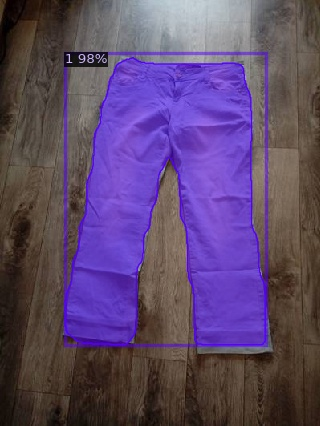

In [11]:
import cv2
from detectron2.data import DatasetCatalog, MetadataCatalog
from detectron2.config import get_cfg
from detectron2.engine import DefaultTrainer, DefaultPredictor
from detectron2.utils.visualizer import Visualizer
from IPython.display import Image

# Step 2: Configure and initialize the model for training
cfg = get_cfg()
cfg.merge_from_file("detectron2/COCO-InstanceSegmentation/mask_rcnn_R_50_FPN_3x.yaml")
cfg.DATASETS.TRAIN = ("dataset_train",)  # Updated dataset name
cfg.DATASETS.TEST = ()  # No test dataset
cfg.DATALOADER.NUM_WORKERS = 2
cfg.MODEL.WEIGHTS = output_model_path
# cfg.SOLVER.BASE_LR = 0.001  # Adjust the learning rate based on your dataset and model architecture
# cfg.SOLVER.MOMENTUM = 0.9  # Momentum for SGD optimizer
# cfg.SOLVER.WEIGHT_DECAY = 0.0001  # Weight decay for regularization
# cfg.SOLVER.GAMMA = 0.1  # Multiplicative factor for reducing learning rate
# cfg.SOLVER.STEPS = (500, 800)  # Decrease the learning rate at these steps
# cfg.SOLVER.MAX_ITER = 1000  # Total number of iterations for training
# cfg.SOLVER.IMS_PER_BATCH = 2  # Batch size

cfg.SOLVER.STEPS = []  # You can add learning rate steps here
cfg.MODEL.ROI_HEADS.BATCH_SIZE_PER_IMAGE = 128  # You can adjust this
cfg.MODEL.ROI_HEADS.NUM_CLASSES = 5  # Updated number of classes

# Enable mask prediction
cfg.MODEL.MASK_ON = True


cfg.MODEL.ROI_HEADS.SCORE_THRESH_TEST = 0.5  # Set a threshold for this model
predictor = DefaultPredictor(cfg)

metadata = MetadataCatalog.get("dataset_train")
# Load a sample image
sample_image_path = "C://Users//admin//Desktop//style_transfer_app//static//images//0e3d71f8-7677-4cd4-ba24-4788c3890ac1.jpg"
sample_image = cv2.imread(sample_image_path)

# Perform inference
outputs = predictor(sample_image)

# Visualize the predictions
v = Visualizer(sample_image[:, :, ::-1], metadata=metadata, scale=0.8)
v = v.draw_instance_predictions(outputs["instances"].to("cpu"))

# Save the visualized image
output_image_path = "sample_result4.jpg"
cv2.imwrite(output_image_path, v.get_image()[:, :, ::-1])

# Display the output image in Jupyter Notebook
Image(filename=output_image_path)


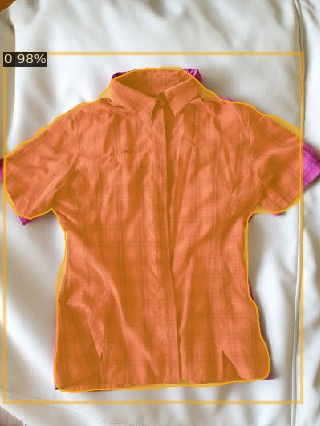

In [12]:
sample_image_path = "C://Users//admin//Desktop//style_transfer_app//static//images//00e745c9-97d9-429d-8c3f-d3db7a2d2991.jpg"
sample_image = cv2.imread(sample_image_path)

# Perform inference
outputs = predictor(sample_image)

# Visualize the predictions
v = Visualizer(sample_image[:, :, ::-1], metadata=metadata, scale=0.8)
v = v.draw_instance_predictions(outputs["instances"].to("cpu"))

# Save the visualized image
output_image_path = "sample_result4.jpg"
cv2.imwrite(output_image_path, v.get_image()[:, :, ::-1])

# Display the output image in Jupyter Notebook
Image(filename=output_image_path)

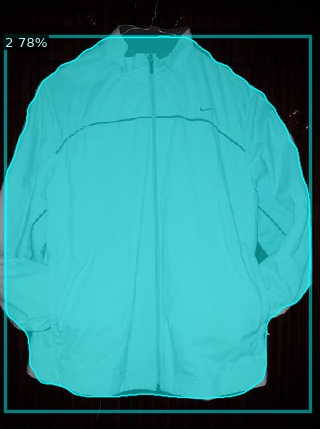

In [13]:
sample_image_path = "C://Users//admin//Desktop//style_transfer_app//static//images//95b40e4e-6a2d-4645-aaee-5683635ff94f.jpg"
sample_image = cv2.imread(sample_image_path)

# Perform inference
outputs = predictor(sample_image)

# Visualize the predictions
v = Visualizer(sample_image[:, :, ::-1], metadata=metadata, scale=0.8)
v = v.draw_instance_predictions(outputs["instances"].to("cpu"))

# Save the visualized image
output_image_path = "sample_result4.jpg"
cv2.imwrite(output_image_path, v.get_image()[:, :, ::-1])

# Display the output image in Jupyter Notebook
Image(filename=output_image_path)

Trial and Error

In [23]:
# Perform inference
outputs = predictor(sample_image)

# Get the predicted instances
instances = outputs["instances"].to("cpu")

# Print the available fields
print("Available fields in instances object:", instances.get_fields().keys())

Available fields in instances object: dict_keys(['pred_boxes', 'scores', 'pred_classes', 'pred_masks'])


In [27]:
# Perform inference
outputs = predictor(sample_image)

# Get the predicted instances
instances = outputs["instances"].to("cpu")

# Print the available fields
print("Available fields in instances object:", instances.get_fields().keys())

# Check if 'pred_masks' is available
if "pred_masks" not in instances.get_fields():
    print("Model does not predict masks!")
else:
    # Extract the segmentation masks
    masks = instances.pred_masks.numpy()

    # Replace the background with white
    background_color = (255, 255, 255)  # White color
    background = np.ones(sample_image.shape, dtype=np.uint8) * background_color

    # Apply the masks to the background
    for mask in masks:
        mask = mask.astype(np.uint8)
        # Create a copy of the background for blending
        blended_image = background.copy()
        # Blend the masked image with the background using numpy operations
        blended_image[mask == 1] = (sample_image[mask == 1] * 0.5 + background[mask == 1] * 0.5).astype(np.uint8)
        # Update the background with the blended image
        background = blended_image

    # Save the resulting image
    output_image_path = "output_image.jpg"
    cv2.imwrite(output_image_path, background)


Available fields in instances object: dict_keys(['pred_boxes', 'scores', 'pred_classes', 'pred_masks'])


In [27]:
# Perform inference
outputs = predictor(sample_image)

# Get the predicted instances
instances = outputs["instances"].to("cpu")

# Print the available fields
print("Available fields in instances object:", instances.get_fields().keys())

# Check if 'pred_masks' is available
if "pred_masks" not in instances.get_fields():
    print("Model does not predict masks!")
else:
    # Extract the segmentation masks
    masks = instances.pred_masks.numpy()

    # Replace the background with white
    background_color = (255, 255, 255)  # White color
    background = np.ones(sample_image.shape, dtype=np.uint8) * background_color

    # Apply the masks to the background
    for mask in masks:
        mask = mask.astype(np.uint8)
        # Create a copy of the background for blending
        blended_image = background.copy()
        # Blend the masked image with the background using numpy operations
        blended_image[mask == 1] = (sample_image[mask == 1] * 0.5 + background[mask == 1] * 0.5).astype(np.uint8)
        # Update the background with the blended image
        background = blended_image

    # Save the resulting image
    output_image_path = "output_image.jpg"
    cv2.imwrite(output_image_path, background)


Available fields in instances object: dict_keys(['pred_boxes', 'scores', 'pred_classes', 'pred_masks'])


In [45]:
from detectron2.engine import DefaultTrainer, DefaultPredictor
predictor = DefaultPredictor(cfg)
# Perform inference
outputs = predictor(sample_image)

# Get the predicted instances
instances = outputs["instances"].to("cpu")

# Print the available fields
print("Available fields in instances object:", instances.get_fields().keys())

# Check if 'pred_masks' is available
if "pred_masks" not in instances.get_fields():
    print("Model does not predict masks!")
else:
    # Extract the segmentation masks
    masks = instances.pred_masks.numpy()

    # Replace the background with white
    background_color = (255, 255, 255)  # White color
    background = np.ones(sample_image.shape, dtype=np.uint8) * background_color

    # Apply the masks to the background
    for mask in masks:
        mask = mask.astype(np.uint8)
        # Create a copy of the background for blending
        blended_image = background.copy()
        # Blend the masked image with the background using numpy operations
        blended_image[mask == 1] = (sample_image[mask == 1] * 0.5 + background[mask == 1] * 0.5).astype(np.uint8)
        # Update the background with the blended image
        background = blended_image

    # Save the resulting image
    output_image_path = "output_image1.jpg"
    cv2.imwrite(output_image_path, background)


[04/29 16:40:40 d2.checkpoint.detection_checkpoint]: [DetectionCheckpointer] Loading from ./output\trained_model.pth ...
Available fields in instances object: dict_keys(['pred_boxes', 'scores', 'pred_classes', 'pred_masks'])
